In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


# Reproducing the results of Baumgart et al
.
We opted not to use the metaphorical terminology of the search theory of Baumgart et al. and rather stick to the target terminology:
Instead of a `Haystack`, we search a `Body`, which instead of containing multiple `Haybales` contains multiple `APCs`, which are either `positive`, making the body `infected` or `negative`, making the body `healthy`.

M := number of positive APCs

N := total number of APCs

$p = M/N :=$ probability of 1 APC to be positive, expressed as an average over all APCs

n := number of checked APCs

k := number of APCs truly identified as positive

$p   =  \frac{M }{N}$

### Global evaluation
When performing a test on multiple APCs, with these metrics you evaluate a T-Cells performance across the whole population to determine how well it can identify a `infected` body.

$TPR =  \frac{TP}{(TP + FN)}$

$FPR =  \frac{FP}{(TN + FP)}$

$TNR =  \frac{TN}{(TN + FP)}$

$FNR =  \frac{FN}{(FN + TP)}$

### Local evaluation
When performing a test on a single APC, with these metrics you evaluate a T-Cells performance on a single case to determine how well it can identify a `positive` APC. While this is not measurable (a population of 1 has either k = 1 for a tp or 0 else), it is controllable via the agent (TCell) policy.

$tpr =  \frac{tp}{(tp + fn)}$

$fpr =  \frac{fp}{(tn + fp)}$

$tnr =  \frac{tn}{(tn + fp)}$

$fnr =  \frac{fn}{(fn + tp)}$






# Setup
## Environment: APC
Each APC is a reinforcement learning environment. It carries the attribute `positiveTendency`, which is either `True` or `False`. This is invisible to the agent. It determines the direction of the evidence function
$$e: t \rightarrow \mathbb{R}$$

### States: S
Each state is an array of three values:
1. the timestep `t`, natural numbers
2. the evidence collected pointing to the APC being positive `q` $\in [0, 1]$. This starts at `0.5` and gets nudged in either direction toward 0 or 1, depending on the environment attribute `positiveTendency`.
3. `1` if this state is a terminal state, `0` at the start of an episode and made positive by the agent

### Actions: A
- `stay`: advance to the next timestep without making a decision
- `positive`: classify the APC to be `positive`
- `negative`: classify the APC to be `negative`

### Rewards: R
The values of the large rewards and penalties are subject to experimentation, as they strongly influence the agent's behaviour.
- `stay`: `-1`, penalty for waiting, encourages making a decision
- `positive`:
    - `tp`: some large reward (e.g. `100`)
    - `fp`: some large penalty (e.g. `-100`)
- `negative`: classify the APC to be `negative`
    - `tn`: some large reward (e.g. `100`)
    - `fn`: some large penalty (e.g. `-100`)

## T-Cell: Agent
The agent for the environments is a TCell.
It has a policy $\pi: S X A \rightarrow \mathbb{R} \in [0,1]$

Since the state-space is continuous, its policy is not tabular but rather a function, which can take many forms. For this purpose we design a `Policy` class, which is flexible and can, for example, be a linear function or a Neural Network.


In [2]:
# play a single episode with a TCell
# use a TCell_Threshold
# this TCell variant uses a simple policy that makes a decision solely based on q
# if q is higher than the treshold or the final timestep is reached and q>0.5, it makes a positive classification
# if q is lower than 1-threshold or the final timestep is reached and q<0.5, it makes a negative classification
# otherwise it waits
# if you don't change the threshold/policy, every episode will converge at the same time
from RL.TCell import TCell_Threshold
from RL.APC import StochasticAPC

# StochasticAPC will pick a random value for isPositive, but you can also set it manually
env = StochasticAPC()
print(f"APC is _{'positive' if env.positiveTendency else 'negative'}_\n")
agent = TCell_Threshold(env, threshold=.995)
print(agent.policy)
# agent.policy.plot(agent)
R, t, transitions = agent.episode(verbose=True)
final_action = transitions[-1][1]
final_reward = transitions[-1][2]
print(f"... and the env was {env.positiveTendency} ...")
agent.plot_transitions(transitions)


APC is _positive_

APCThresholdPolicy threshold=0.995
Starting episode:
State t=0, q=0.5, stop=False
a_0: stay

State t=1, q=0.5, stop=False
a_1: stay

State t=2, q=0.6667, stop=False
a_2: stay

State t=3, q=0.75, stop=False
a_3: stay

State t=4, q=0.8, stop=False
a_4: stay

State t=5, q=0.8333, stop=False
a_5: stay

State t=6, q=0.8571, stop=False
a_6: stay

State t=7, q=0.875, stop=False
a_7: stay

State t=8, q=0.8889, stop=False
a_8: stay

State t=9, q=0.9, stop=False
a_9: stay

State t=10, q=0.9091, stop=False
a_10: stay

State t=11, q=0.9167, stop=False
a_11: stay

State t=12, q=0.9231, stop=False
a_12: stay

State t=13, q=0.9286, stop=False
a_13: stay

State t=14, q=0.9333, stop=False
a_14: stay

State t=15, q=0.9375, stop=False
a_15: stay

State t=16, q=0.9412, stop=False
a_16: stay

State t=17, q=0.9444, stop=False
a_17: stay

State t=18, q=0.9474, stop=False
a_18: stay

State t=19, q=0.95, stop=False
a_19: stay

State t=20, q=0.9524, stop=False
a_20: stay

State t=21, q=0.9545

ValueError: too many values to unpack (expected 2)

In [ ]:
import random

# Recreating fig 2
# increase of TPR over the number of examined APCs
# the curve is shaped more flatly with a lower probability of the APC being positive


m = 1000
n = 100
env = StochasticAPC()
results = []
thresh = 0.997

p = 0.1

agent = TCell_Threshold(env, T=300, threshold=thresh)
for i in range(m):
    for j in range(n):
        # reset the env
        agent.env.reset()
        R, t, transitions = agent.episode(epsilon=0, verbose=False)
        final_action = transitions[-1][1]
        final_reward = transitions[-1][2]
        result = env.eval_action_reward(final_action, final_reward)
        results.append({"result":result, "t":t, "n": i, "p": p})


results = pd.DataFrame(results)
results = results.groupby("n")["result"].value_counts().unstack(fill_value=0).reset_index()
results["TP"] = results.get("TP", 0)
results["FP"] = results.get("FP", 0)
results["TN"] = results.get("TN", 0)
results["FN"] = results.get("FN", 0)
results["TPR"] = results["TP"] / (results["TP"] + results["FN"] + 1)
# # compute the rolling mean (centered so it smooths past & future points)
results['TPR_smooth'] = (
    results['TPR']
    .rolling(window=3, min_periods=1, center=True)
    .mean()
)
print(results)
results.plot.line("n", "TPR", xlabel="num searched APCs", title="")
# results.plot.line("n", "TPR_smooth", xlabel="search time", title="Search time vs TPR")



Baumgart et al. display a plot that shows the development of the global TPR as the number of checked APCs increases, for different probabilities of harmfulness. Here we recreate this plot using our environments


result    t     FN     FP     TN     TP       TPR  TPR_smooth
0         2  22144  22325  44528  44503  0.667732    0.708945
1         3   8306   8254  24998  24942  0.750158    0.739551
2         4   3966   4070  16020  15944  0.800763    0.793859
3         5   2234   2199  11104  10963  0.830656    0.830293
4         6   1342   1372   8073   8213  0.859460    0.855898
..      ...    ...    ...    ...    ...       ...         ...
68      177      1      0    261    238  0.991667    0.990875
69      199      0      0    244    256  0.996109    0.991577
70      228      2      0    271    227  0.986957    0.992960
71      266      0      2    260    238  0.995816    0.993571
72      299      2      2   1542   1454  0.997941    0.996878

[73 rows x 7 columns]


<Axes: title={'center': 'Search time vs TPR'}, xlabel='search time'>

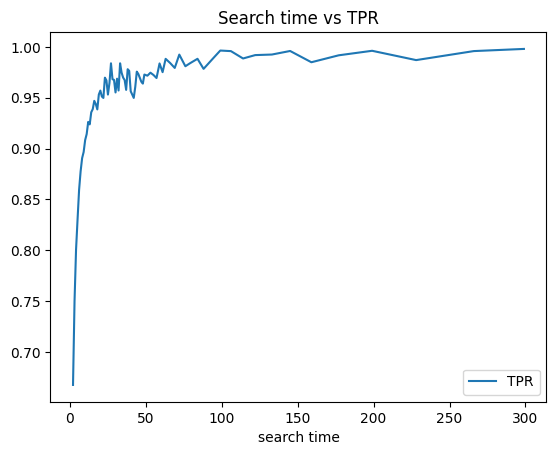

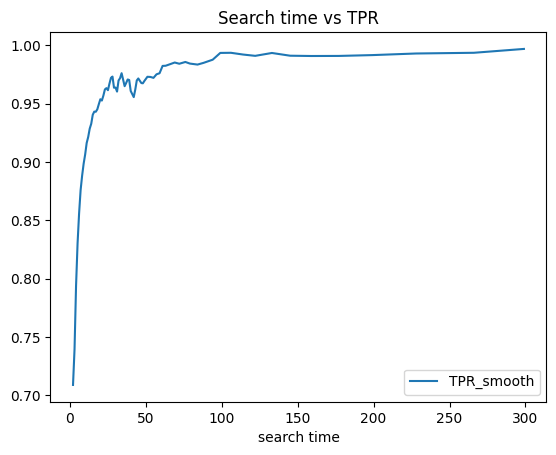

In [10]:


n=500
# test many different TCell_Treshold instances with
# varying thresholds
# plot their results: FPR vs treshold
env = StochasticAPC()
results = []

num_steps = 800  # number of steps
for thresh in np.linspace(0.5, 1.0, num_steps):
    # make 100 episodes per each of the 100 different treshold levels
    agent = TCell_Threshold(env, T=300, threshold=thresh)
    for j in range(n):
        # reset the env
        agent.env.reset()
        R, t, transitions = agent.episode(epsilon=0.1, verbose=False)
        final_action = transitions[-1][1]
        final_reward = transitions[-1][2]
        result = env.eval_action_reward(final_action, final_reward)
        results.append({"result":result, "t":t, "thresh": thresh})
results = pd.DataFrame(results)
results = results.groupby("t")["result"].value_counts().unstack(fill_value=0).reset_index()
results["TP"] = results.get("TP", 0)
results["FP"] = results.get("FP", 0)
results["TN"] = results.get("TN", 0)
results["FN"] = results.get("FN", 0)
results["TPR"] = results["TP"] / (results["TP"] + results["FN"] + 1)
# compute the rolling mean (centered so it smooths past & future points)
results['TPR_smooth'] = (
    results['TPR']
    .rolling(window=3, min_periods=1, center=True)
    .mean()
)
print(results)
results.plot.line("t", "TPR", xlabel="search time", title="Search time vs TPR")
results.plot.line("t", "TPR_smooth", xlabel="search time", title="Search time vs TPR")

